In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df.shape

(397, 2)

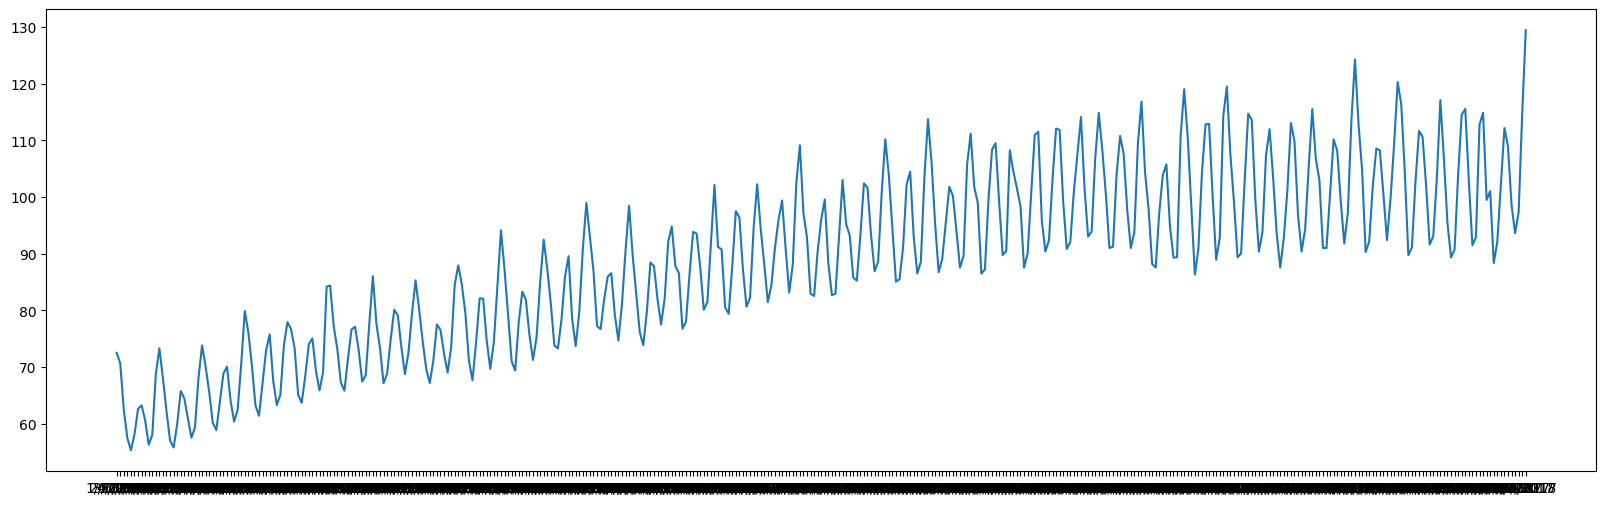

In [4]:
plt.plot(df['DATE'], df['IPG2211A2N'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [6]:
df.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [7]:
df.rename(columns={'IPG2211A2N':'values'}, inplace=True)

In [8]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [9]:
df.head()

,DATE,values
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [10]:
df.describe()

,values
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [11]:
df.set_index('DATE',inplace=True)

In [12]:
df.columns

Index(['values'], dtype='object')

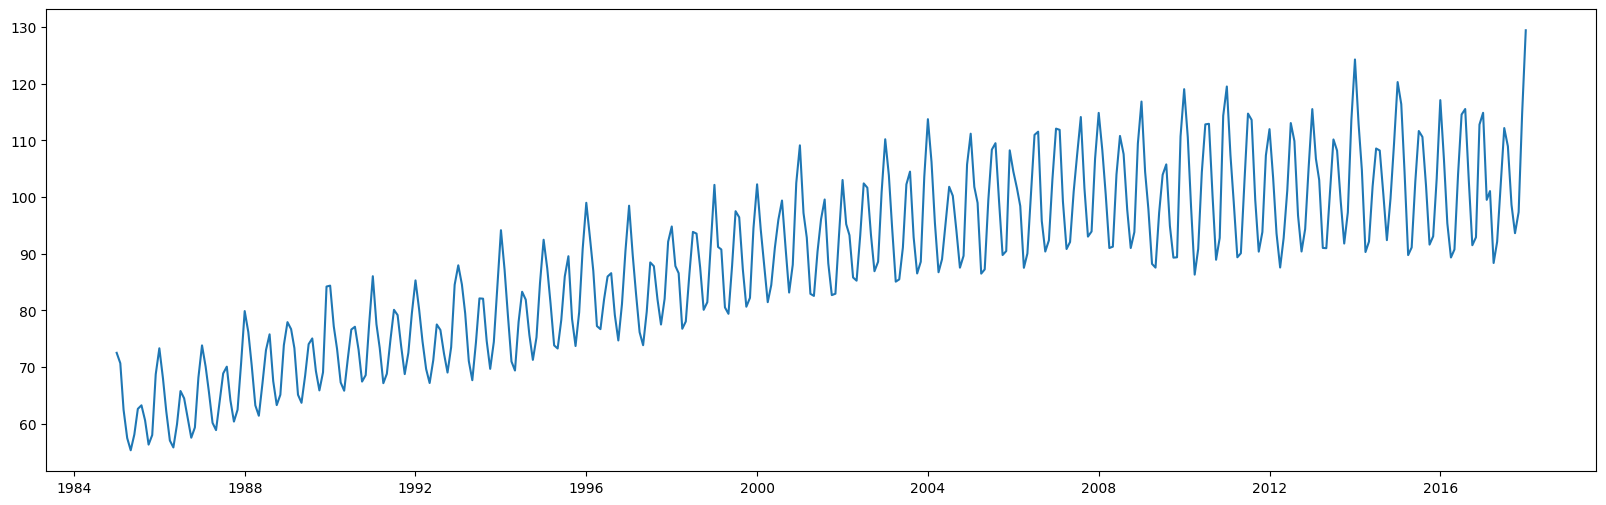

In [13]:
plt.plot(df.index, df.values)

<Axes: >

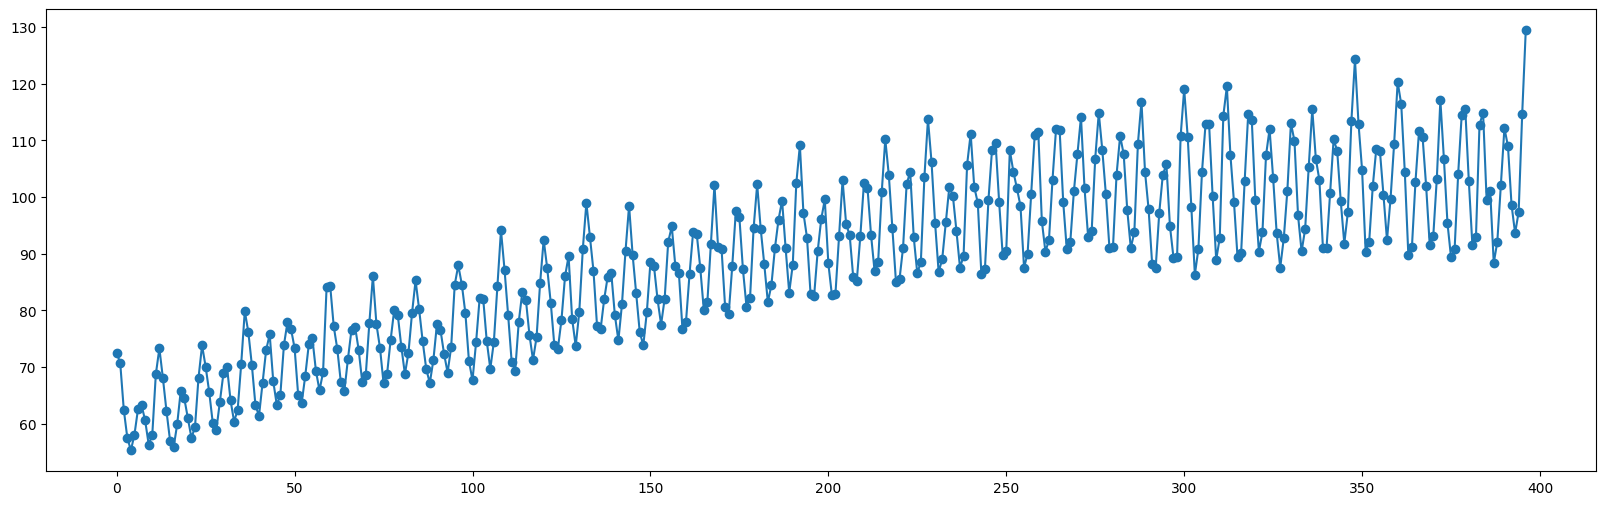

In [14]:
pd.Series(df['values'].values).plot(style='-o')

## Lets apply a Moving average

This is a centered moving average

<Axes: xlabel='DATE'>

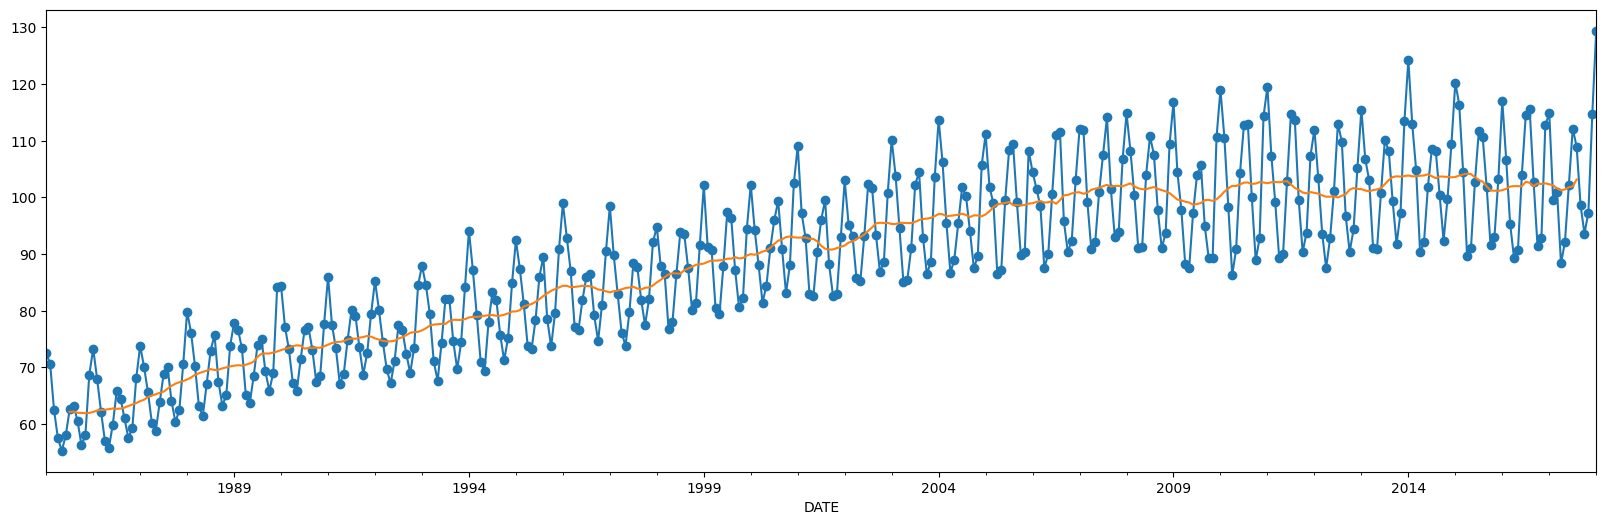

In [15]:
pd.Series(df['values']).plot(style='-o')
pd.Series(df['values']).rolling(12, center=True).mean().plot()

## Decomposition

In [16]:
import statsmodels.api as sm
import statsmodels.tsa as tsa

model = sm.tsa.seasonal_decompose(df['values'], model='additive')

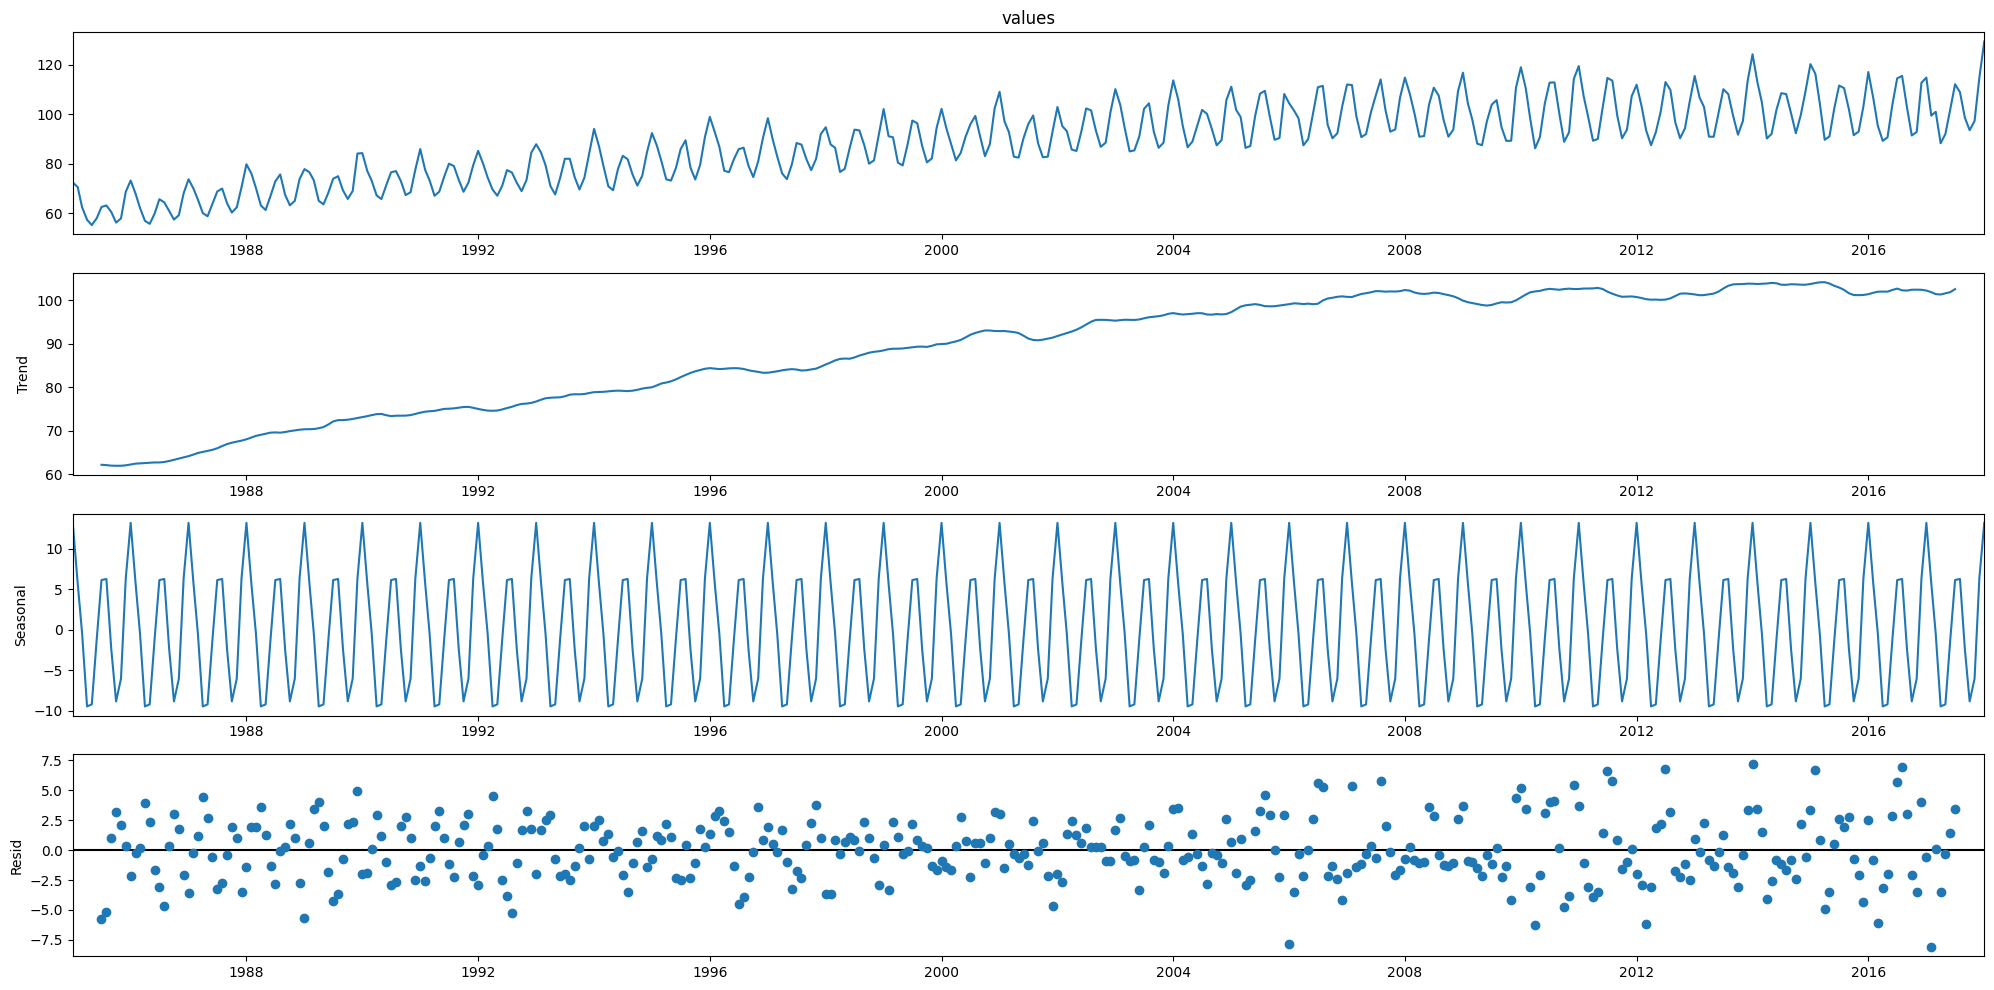

In [17]:
plt.rcParams['figure.figsize'] = (20, 10)
model.plot();

<Axes: xlabel='DATE'>

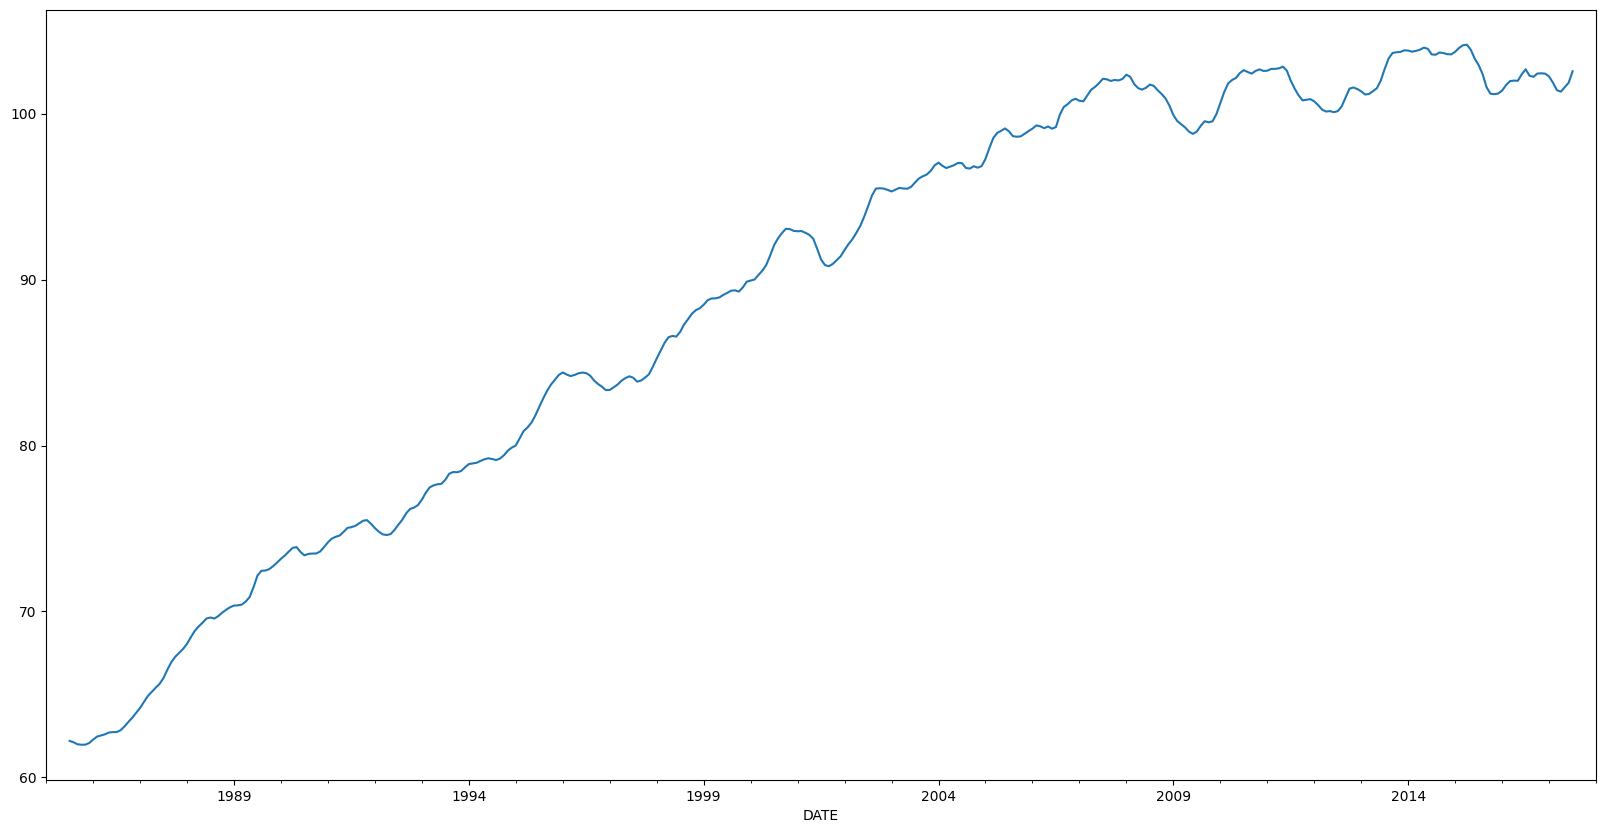

In [18]:
model.trend.plot()

## Simple forcasting techniques

In [19]:
from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_squared_error as mse,
    mean_absolute_percentage_error as mape
)


def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [20]:
train_x = df.loc[df.index < df.index[-12]].copy()
test_x = df.loc[df.index >= df.index[-12]].copy()

test_x

,values
DATE,
2017-02-01,99.4901
2017-03-01,101.0396
2017-04-01,88.3530
2017-05-01,92.0805
2017-06-01,102.1532
2017-07-01,112.1538
2017-08-01,108.9312
2017-09-01,98.6154
2017-10-01,93.6137


In [21]:
# Create a pandas Series from the data
series = pd.Series(df.values.flatten())

model = sm.tsa.SimpleExpSmoothing(series).fit(smoothing_level=0.8)
pred = model.forecast(12)

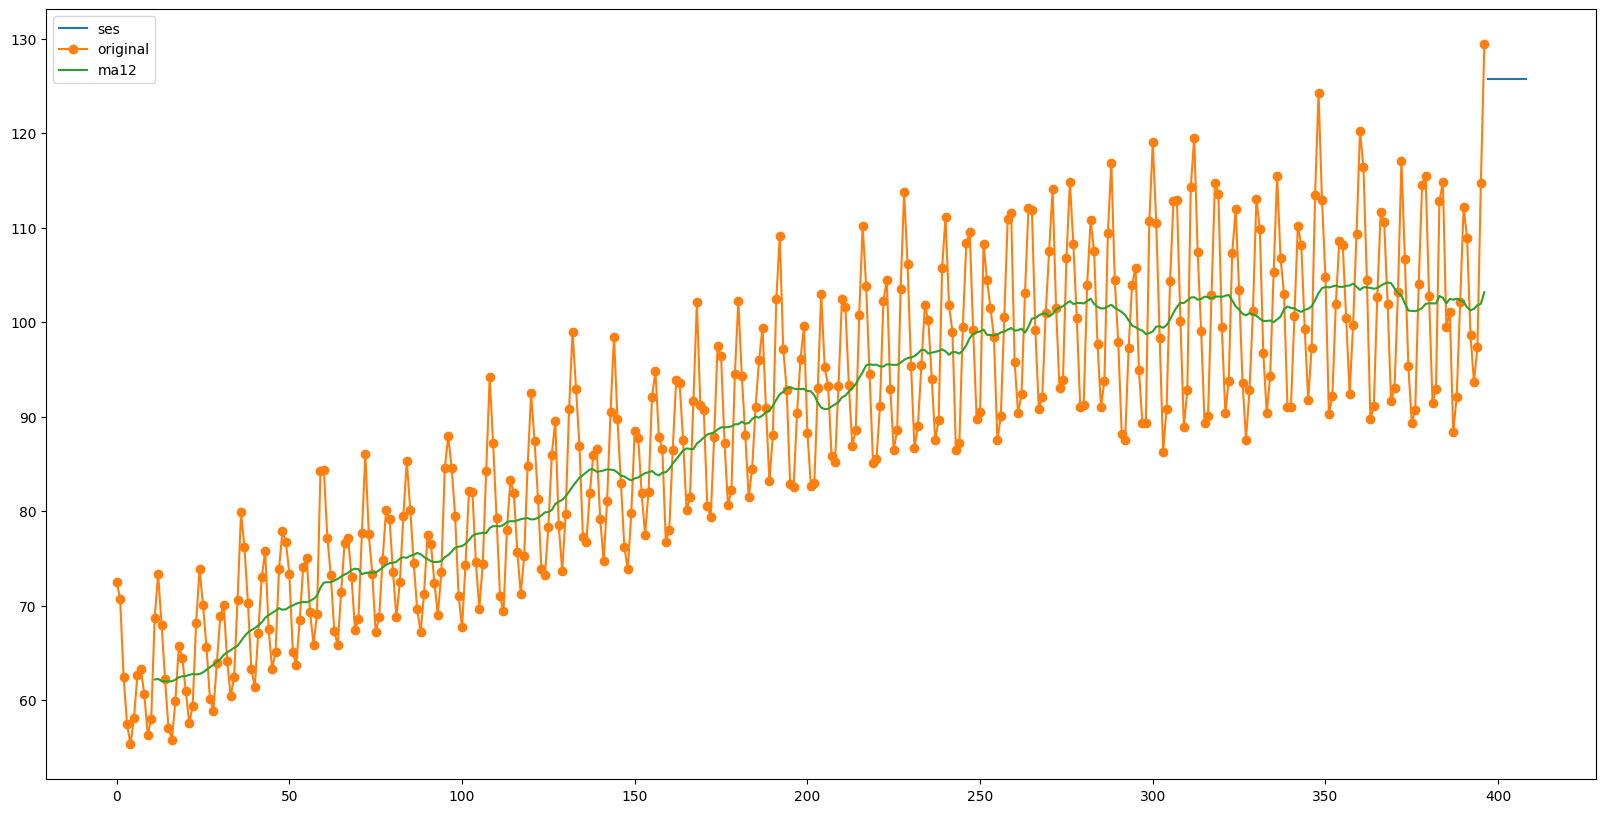

In [22]:
# pred = pd.Series(sm.tsa.SimpleExpSmoothing(df.values).fit(smoothing_level=1/(2*12)).fittedvalues)

pred.plot(label='ses')
series.plot(label='original', style='-o')
series.rolling(12).mean().plot(label='ma12')
plt.legend()

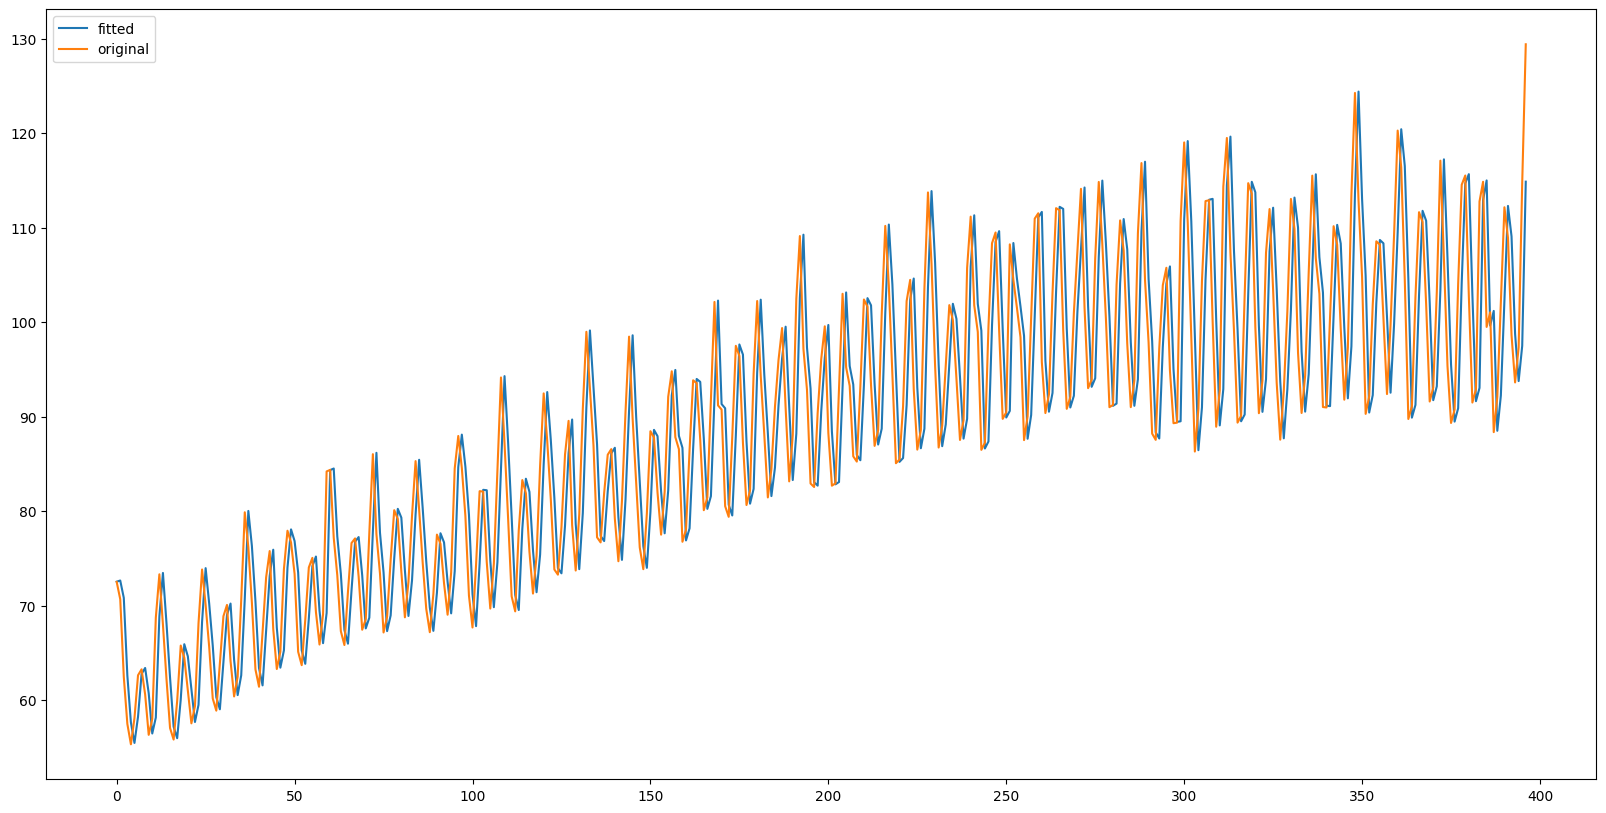

In [23]:
model = sm.tsa.ExponentialSmoothing(series, trend='add').fit()
model.fittedvalues.plot(label='fitted')
series.plot(label='original')
plt.legend()

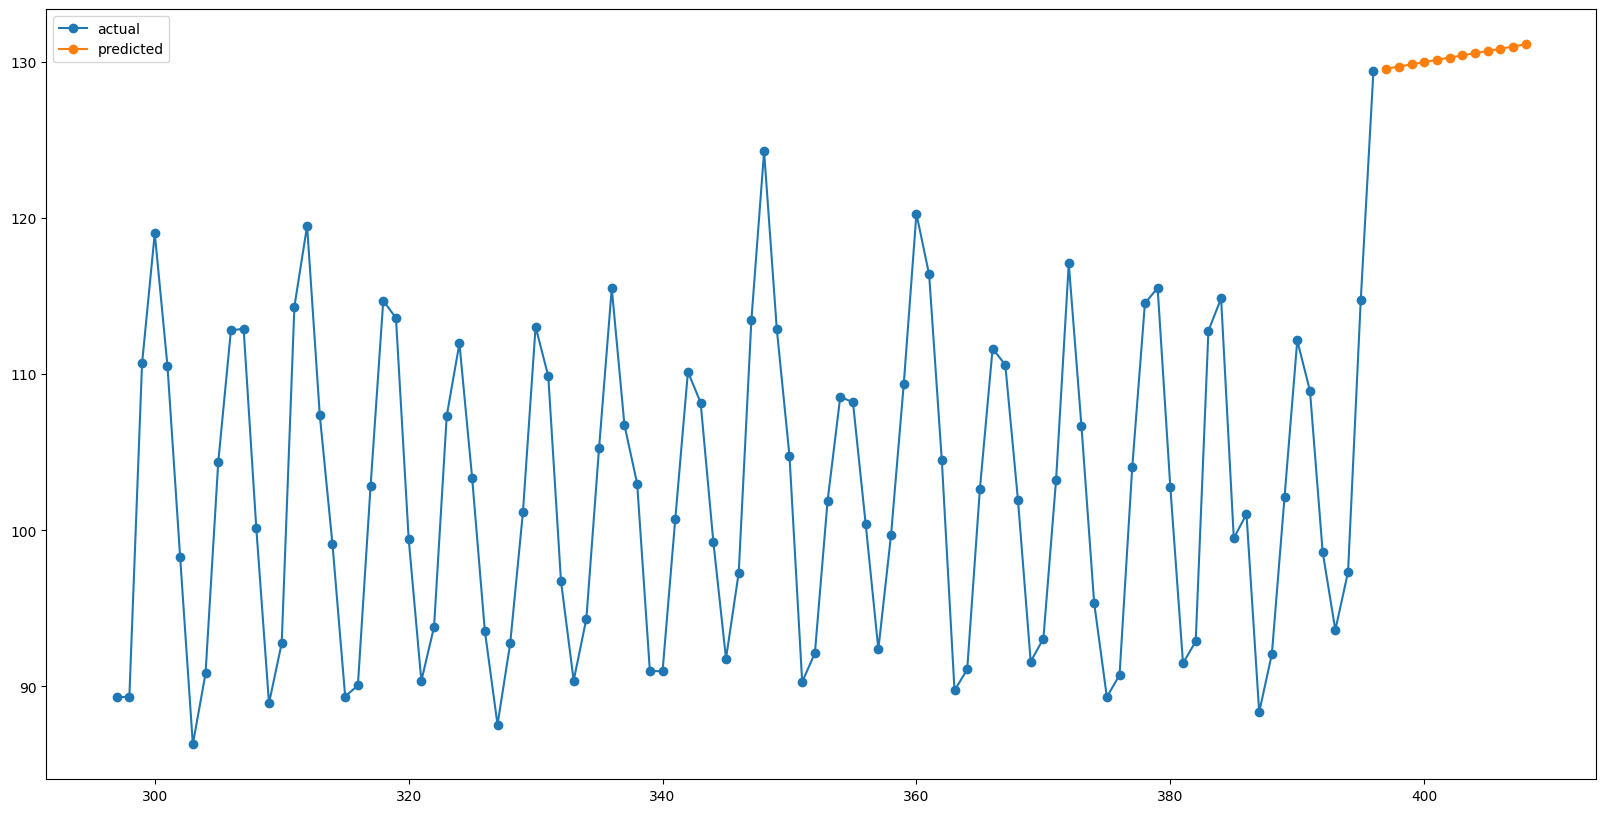

In [24]:
pred = model.forecast(steps = 12)
series.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

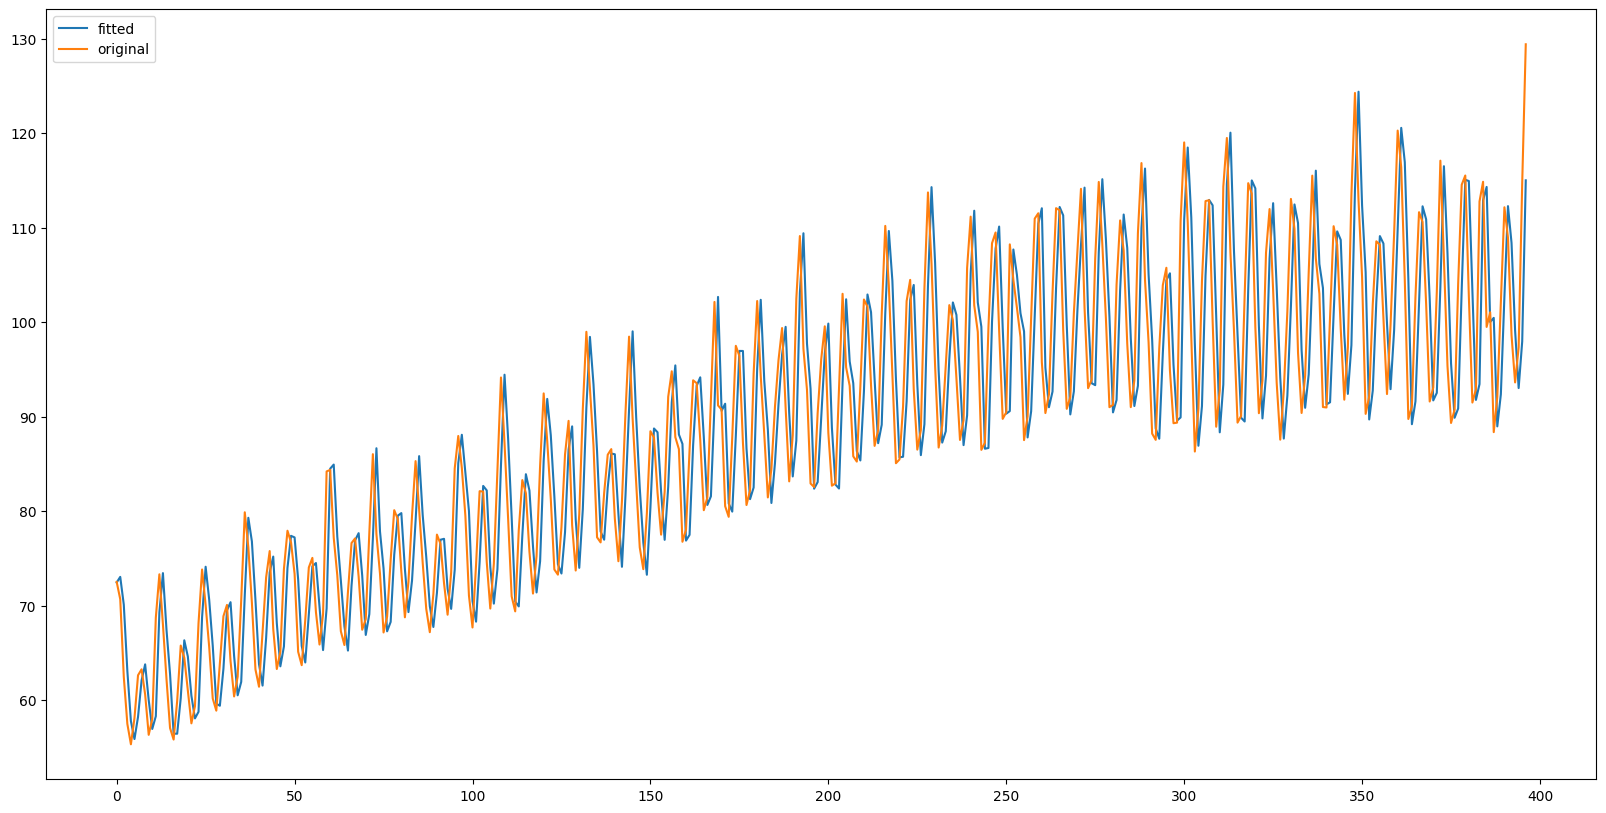

In [25]:
model = sm.tsa.ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=7).fit()

model.fittedvalues.plot(label='fitted')
series.plot(label='original')
plt.legend()

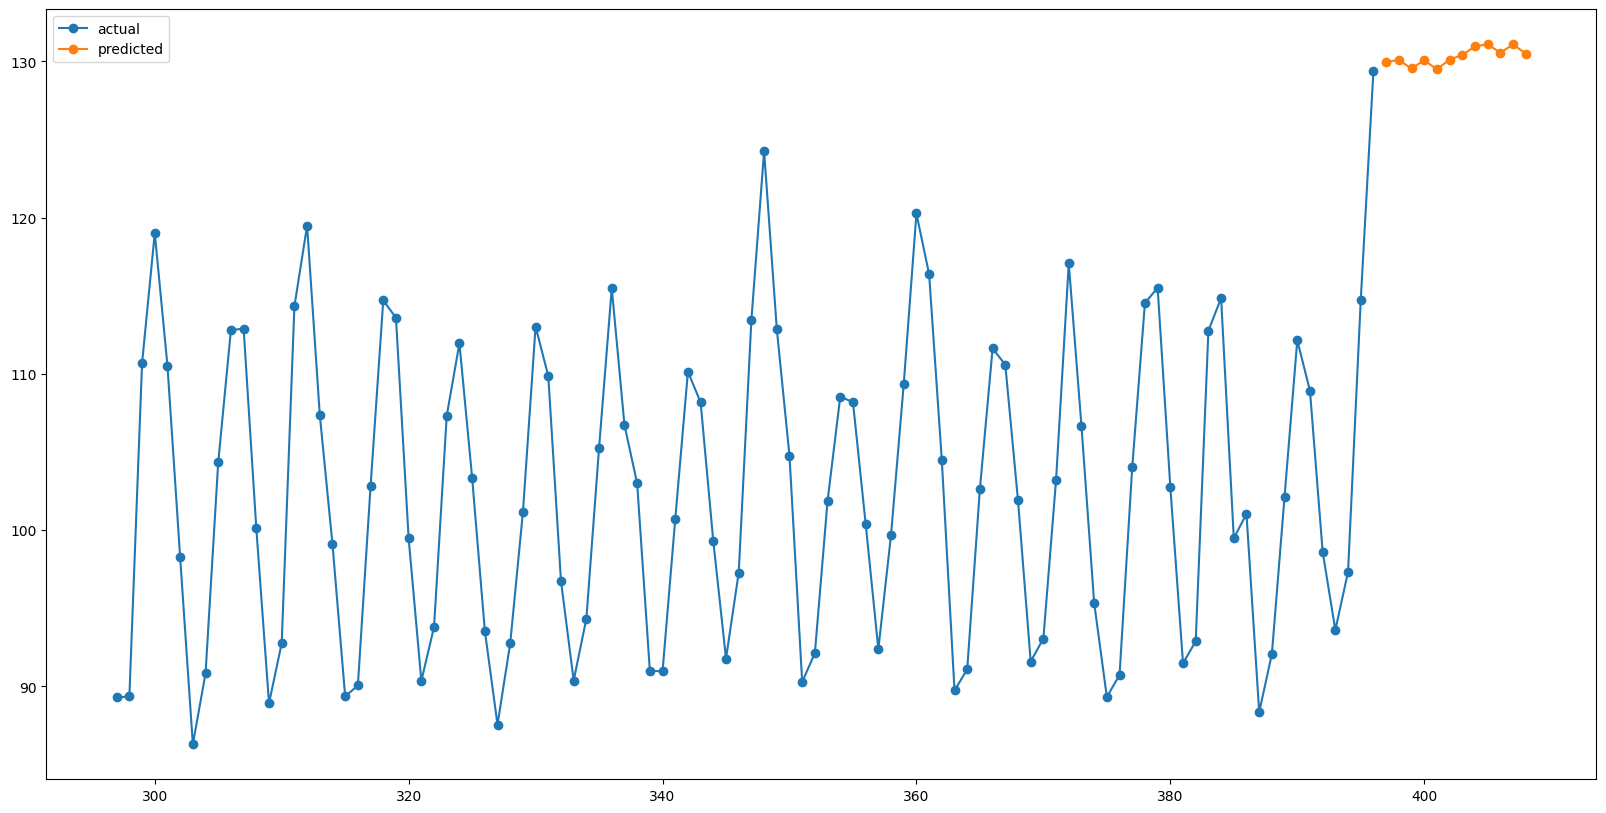

In [26]:
pred = model.forecast(steps = 12)
series.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

### Dickey-Fuller test

In [27]:
sm.tsa.stattools.adfuller(series)[1]

0.1862146911658717

In [28]:
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

adf_test(series)

Sequence is not stationary


In [30]:
import statsmodels.api as sm

model = sm.tsa.seasonal_decompose(df['values'], model='additive')

<Axes: xlabel='DATE'>

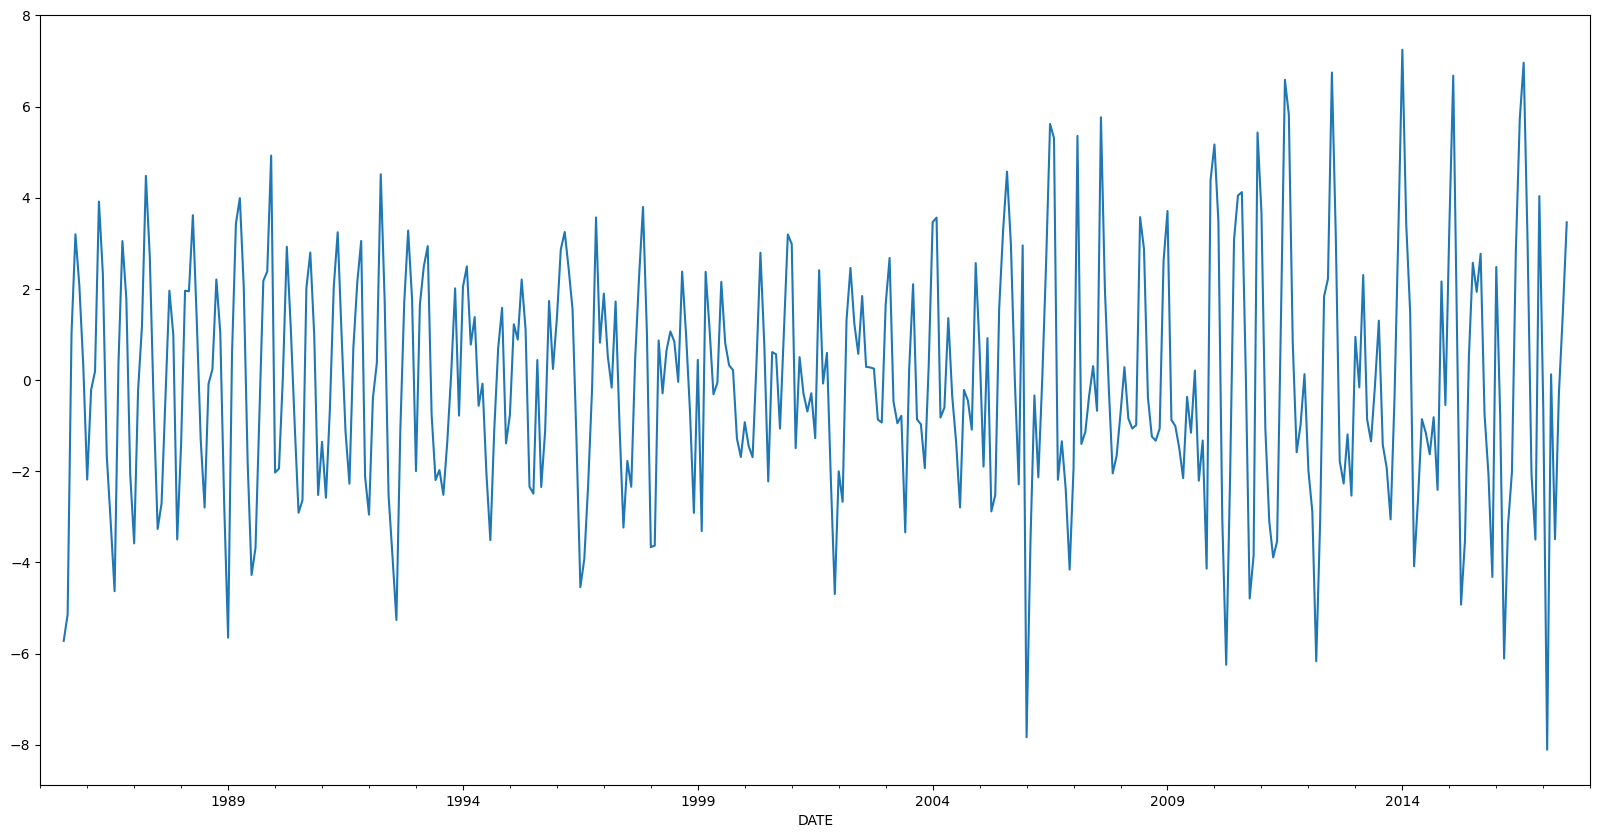

In [31]:
model.resid.plot()

<Axes: >

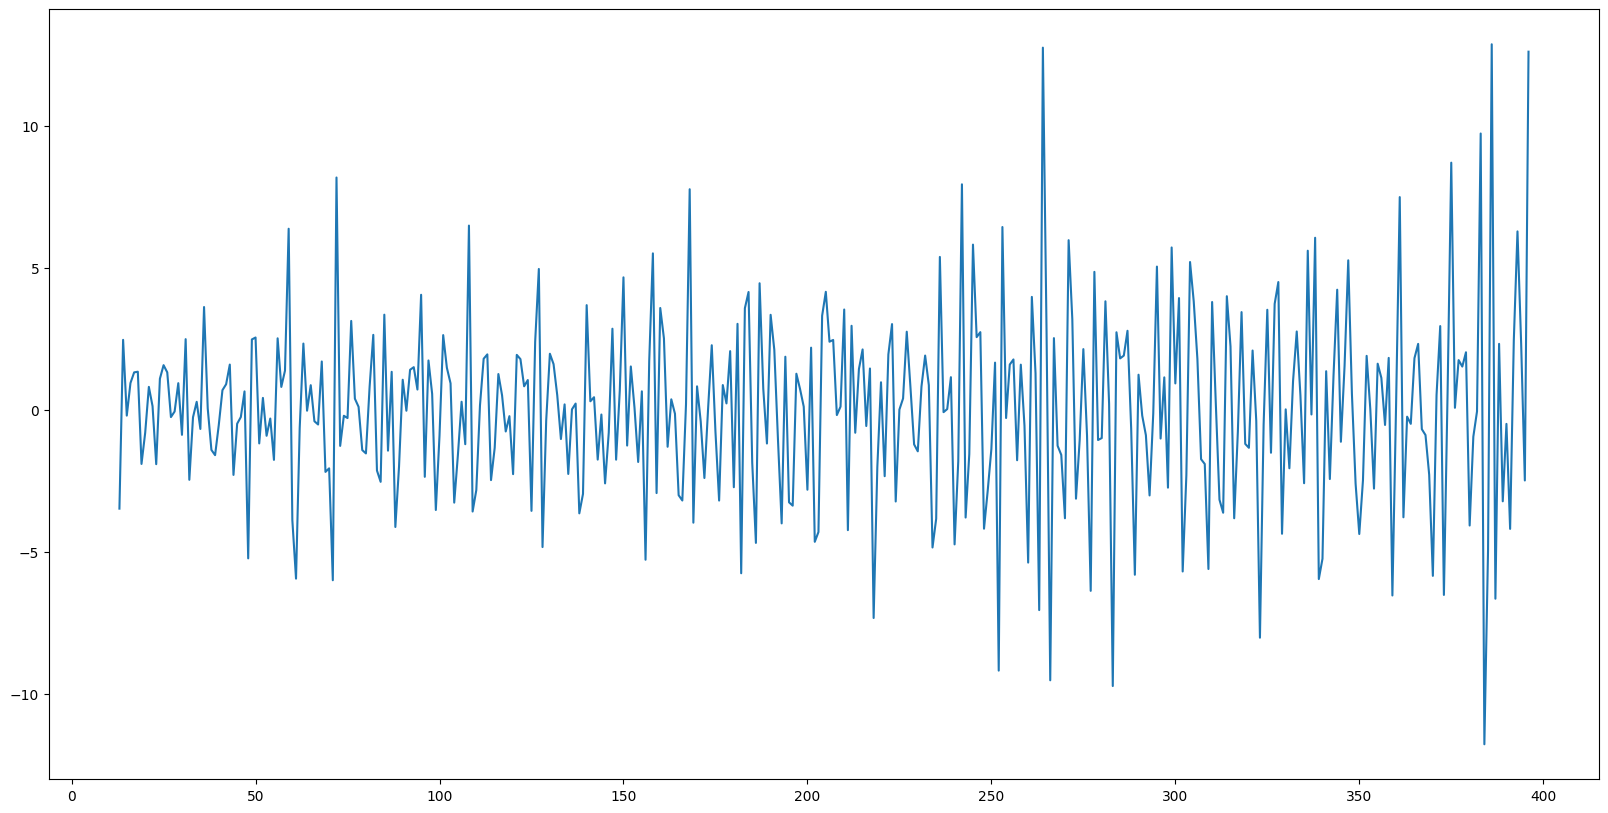

In [32]:
series.diff(12).diff(1).plot()

In [33]:
adf_test(series.diff(12).diff(1).dropna())

Sequence is stationary


In [34]:
np.corrcoef(series[1:], series.shift(1).dropna())[0][1]

0.8717308657532118

<StemContainer object of 3 artists>

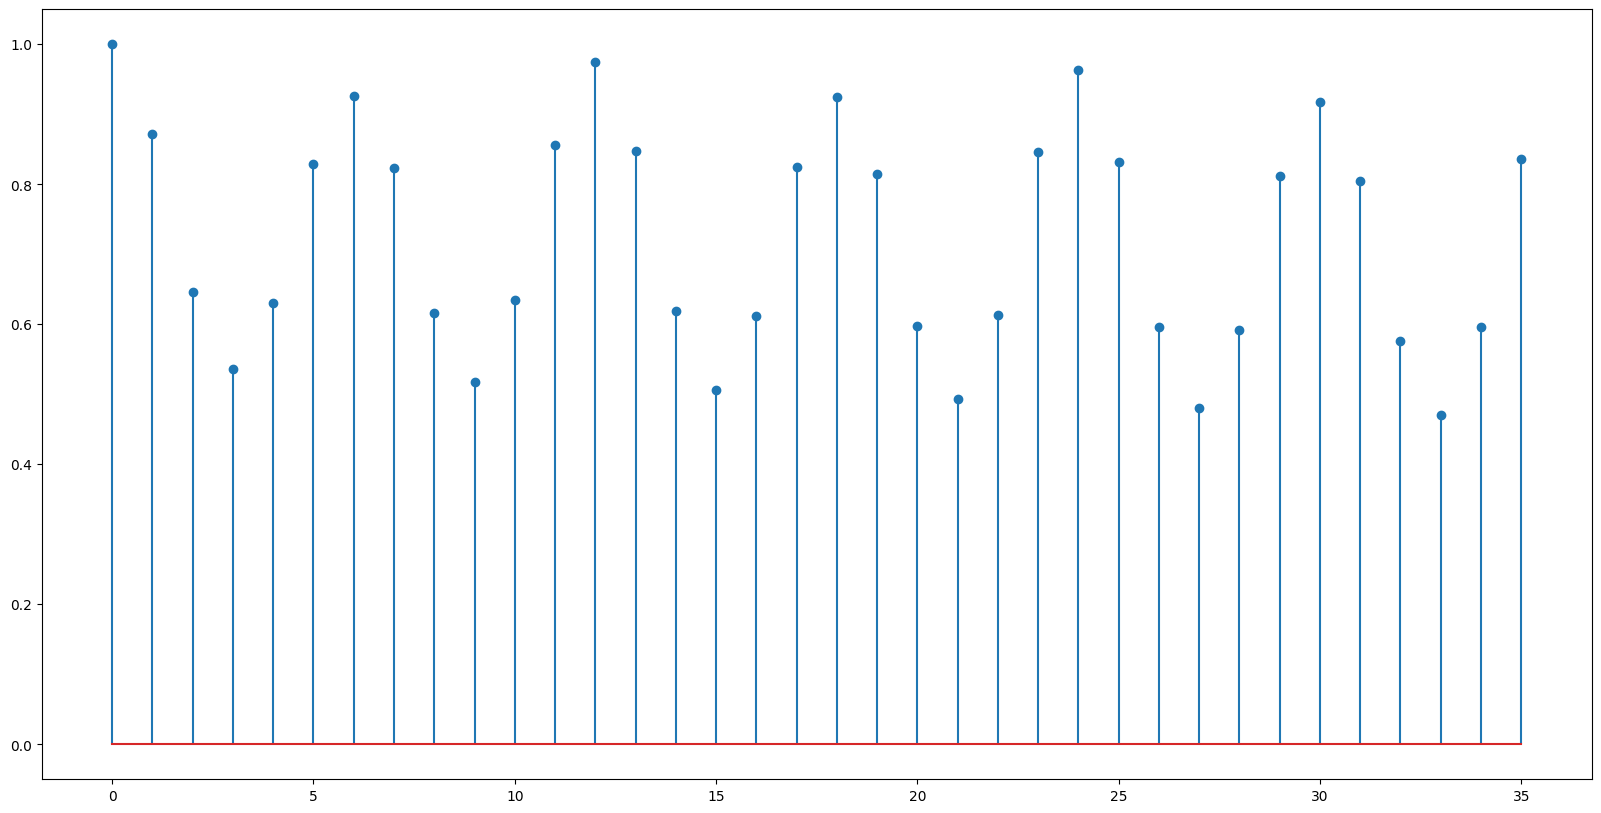

In [35]:
corr = []
for lag in range(36):
    corr.append(np.corrcoef(series[lag:], series.shift(lag).dropna())[0][1])

plt.stem(np.arange(36), corr)

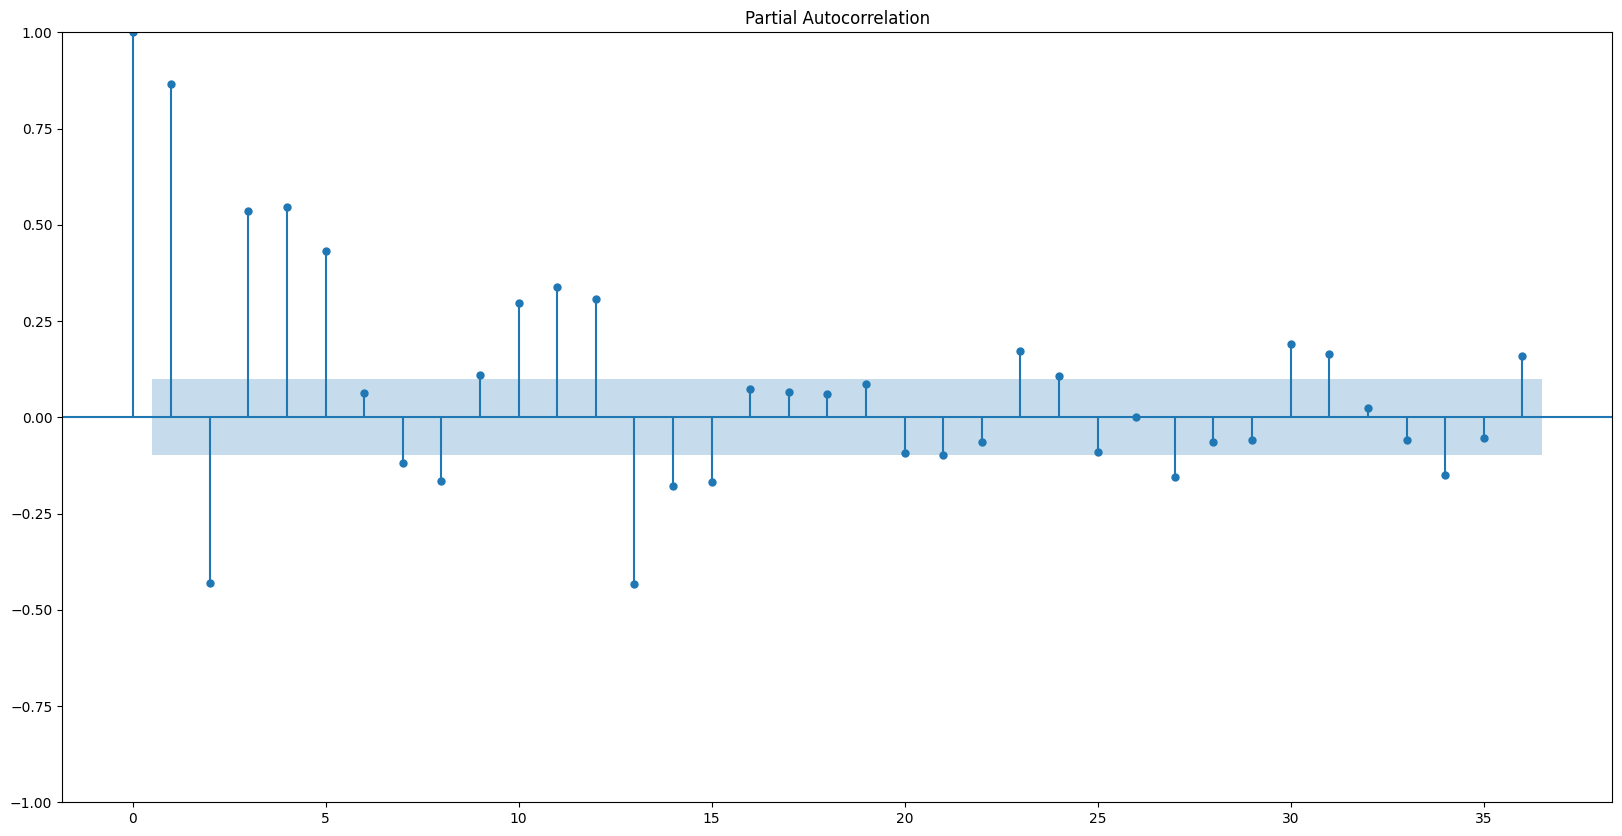

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_pacf(series, lags=36);

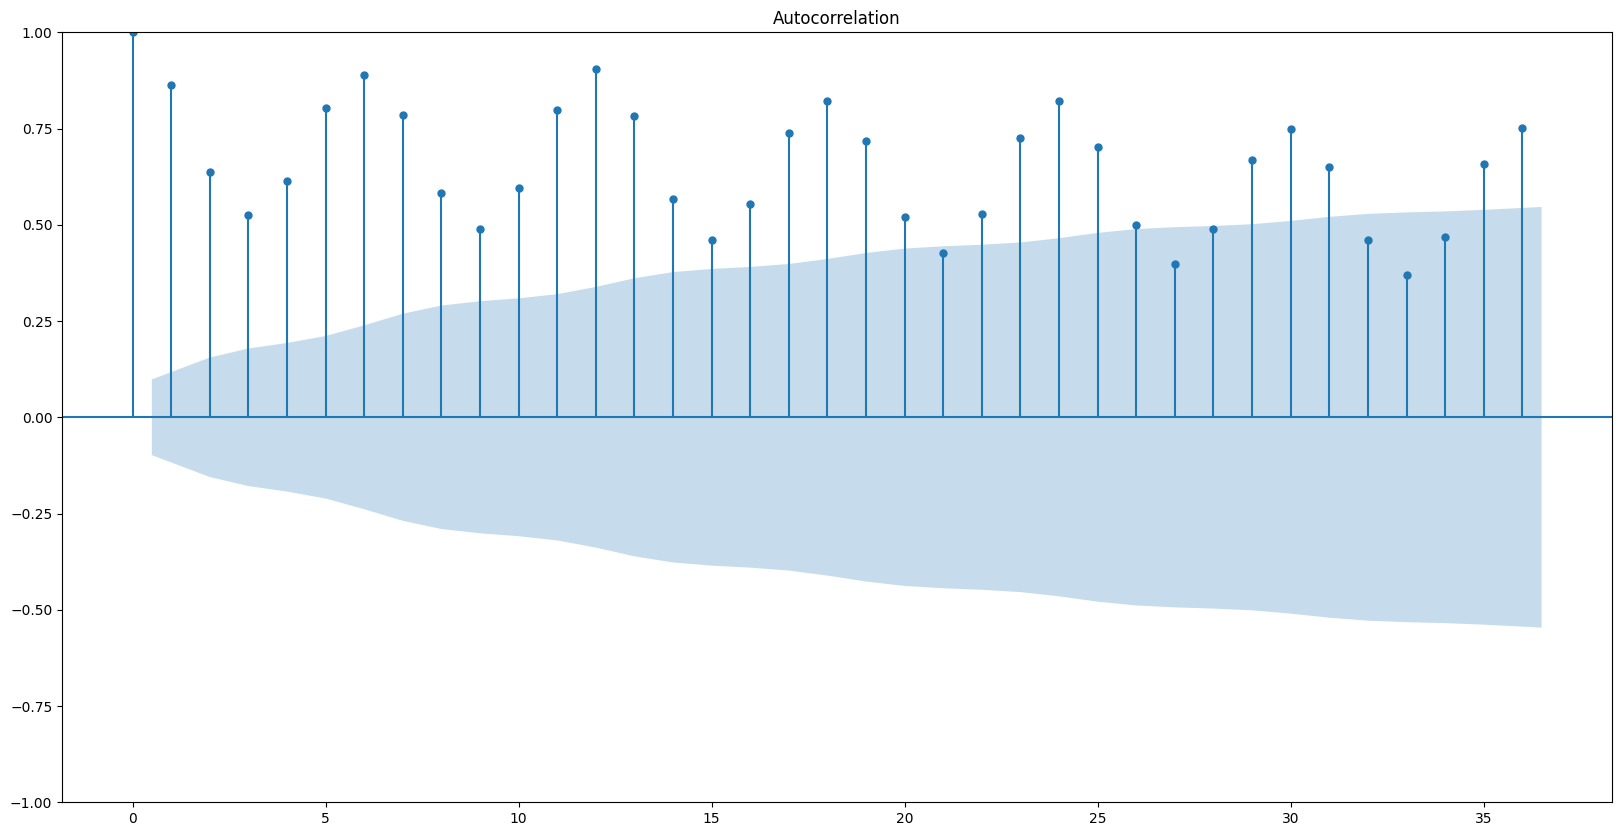

In [37]:
plot_acf(series, lags=36);

--- 
# ARIMA FAMILY

In [45]:
train_x = df.loc[df.index < df.index[-12]].copy()
test_x = df.loc[df.index >= df.index[-12]].copy()

train_x.shape

(385, 1)

In [44]:
test_x.shape

(12, 1)

In [46]:
train_x.head()

,values
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
train_x_st = train_x.copy()

train_x_st.values = train_x_st['values'].diff(1)
train_x_st.dropna(inplace=True)

adf_test(train_x_st.values)

Sequence is stationary


## AR(p)

/Users/aryan/miniconda3/envs/adv_ds/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE : 4.241
RMSE : 5.662
MAPE: 0.039


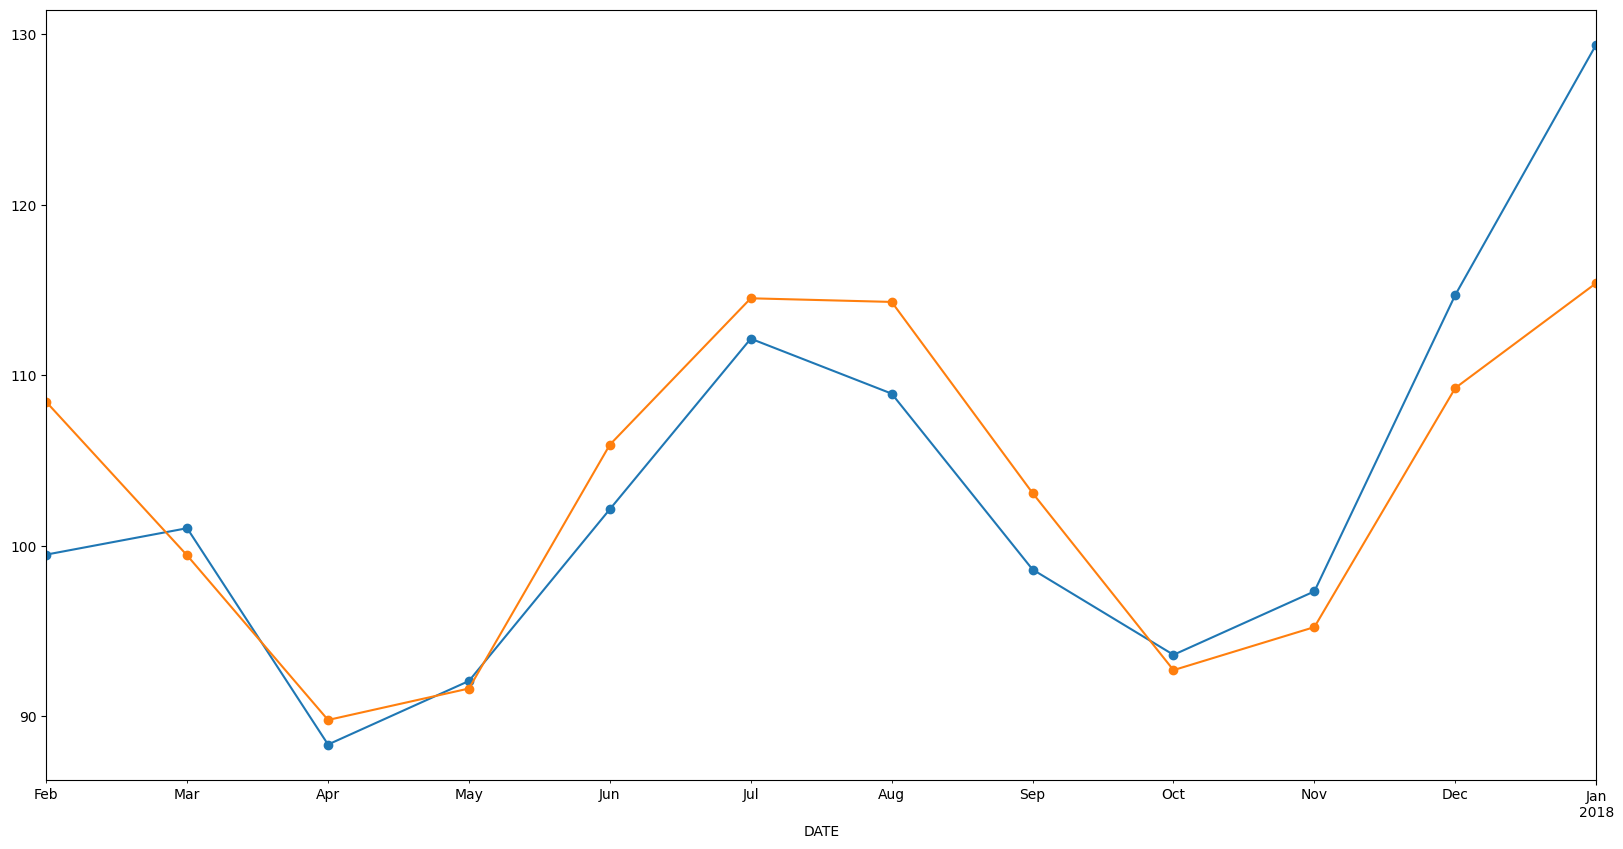

In [56]:
model = SARIMAX(train_x_st.values, order=(25, 0, 0)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

# integrate it back to non-stationary level
test_x['pred'] = test_x['pred'].cumsum() + train_x.values[-1]

test_x['values'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['values'], test_x['pred'])

## MA(q)

/Users/aryan/miniconda3/envs/adv_ds/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE : 6.287
RMSE : 8.618
MAPE: 0.059


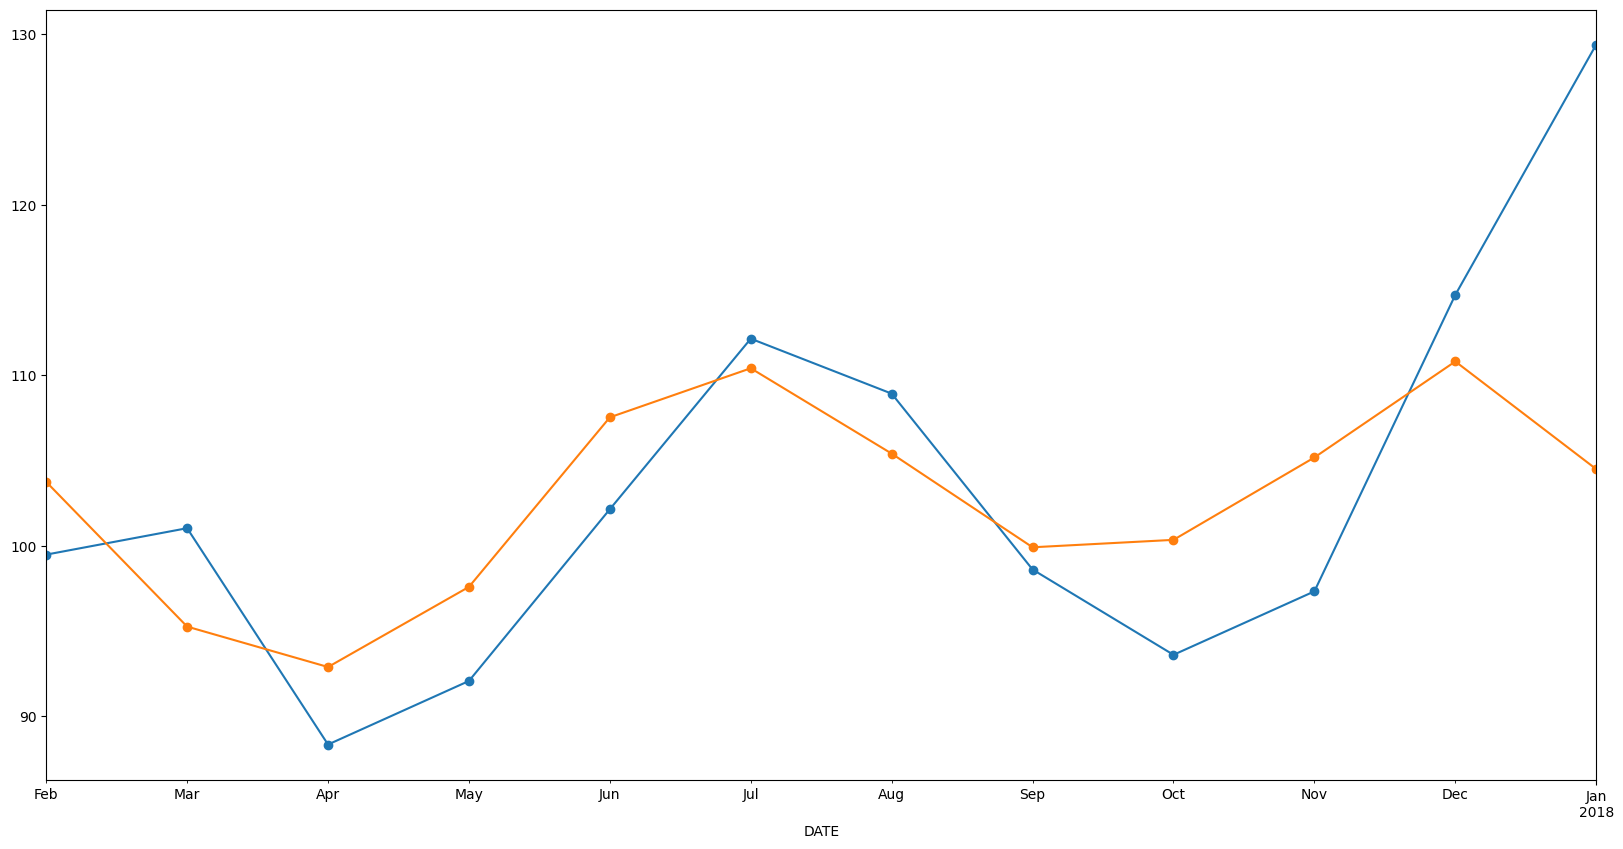

In [61]:
model = SARIMAX(train_x_st.values, order=(0, 0, 15)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

# integrate it back to non-stationary level
test_x['pred'] = test_x['pred'].cumsum() + train_x.values[-1]

test_x['values'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['values'], test_x['pred'])

### ARMA(p, q)

/Users/aryan/miniconda3/envs/adv_ds/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE : 3.839
RMSE : 5.281
MAPE: 0.036


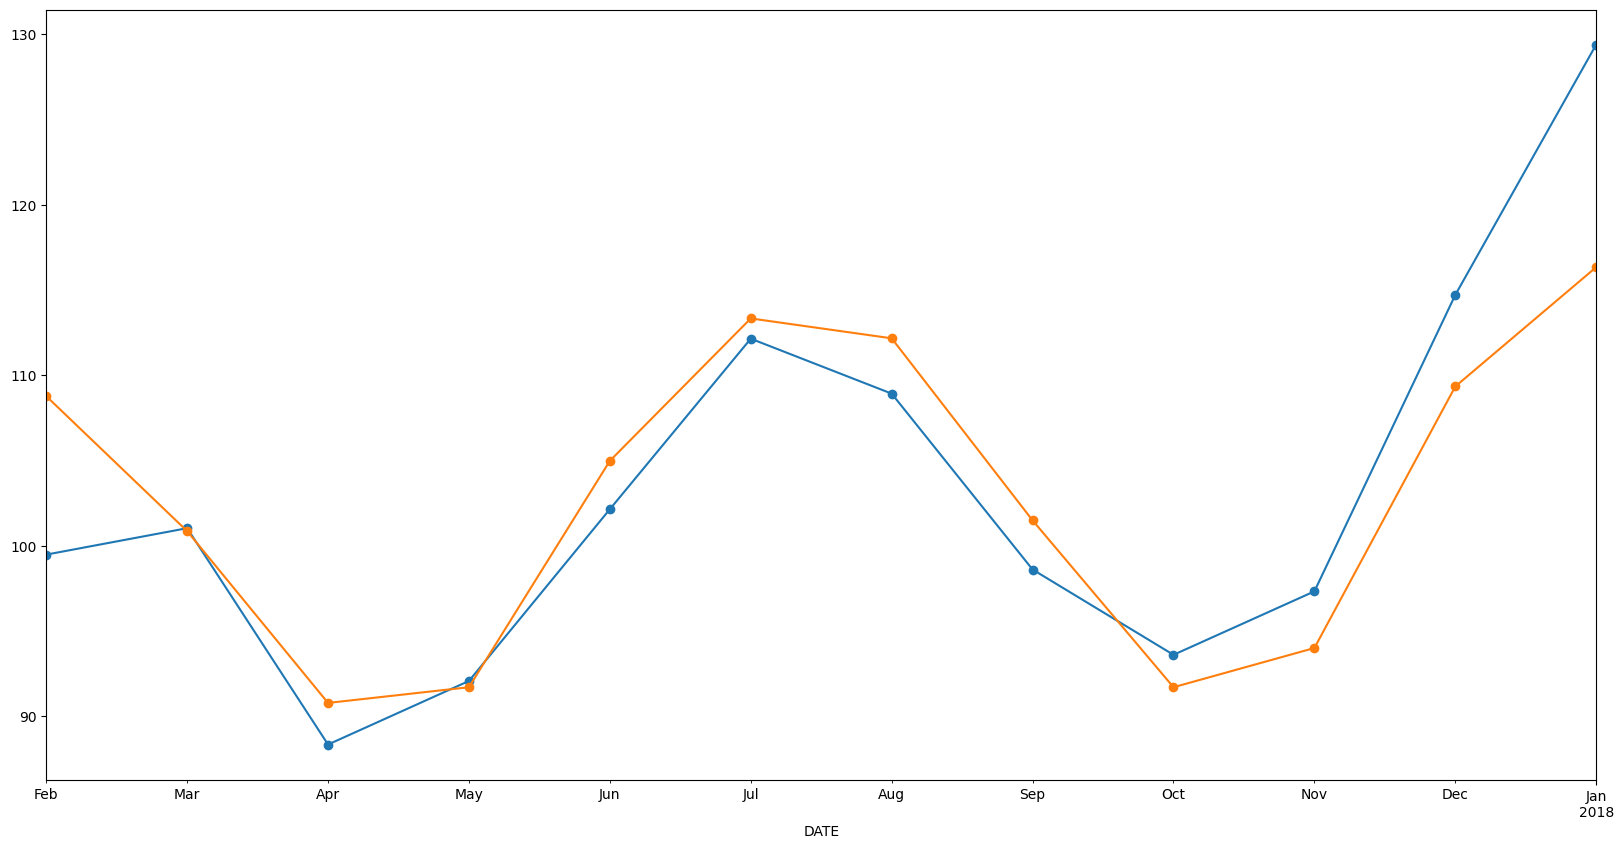

In [65]:
model = SARIMAX(train_x_st.values, order=(25, 0, 15)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

# integrate it back to non-stationary level
test_x['pred'] = test_x['pred'].cumsum() + train_x.values[-1]

test_x['values'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['values'], test_x['pred'])

### ARIMA (p,d,q)

MAE : 4.952
RMSE : 6.835
MAPE: 0.046


/Users/aryan/miniconda3/envs/adv_ds/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


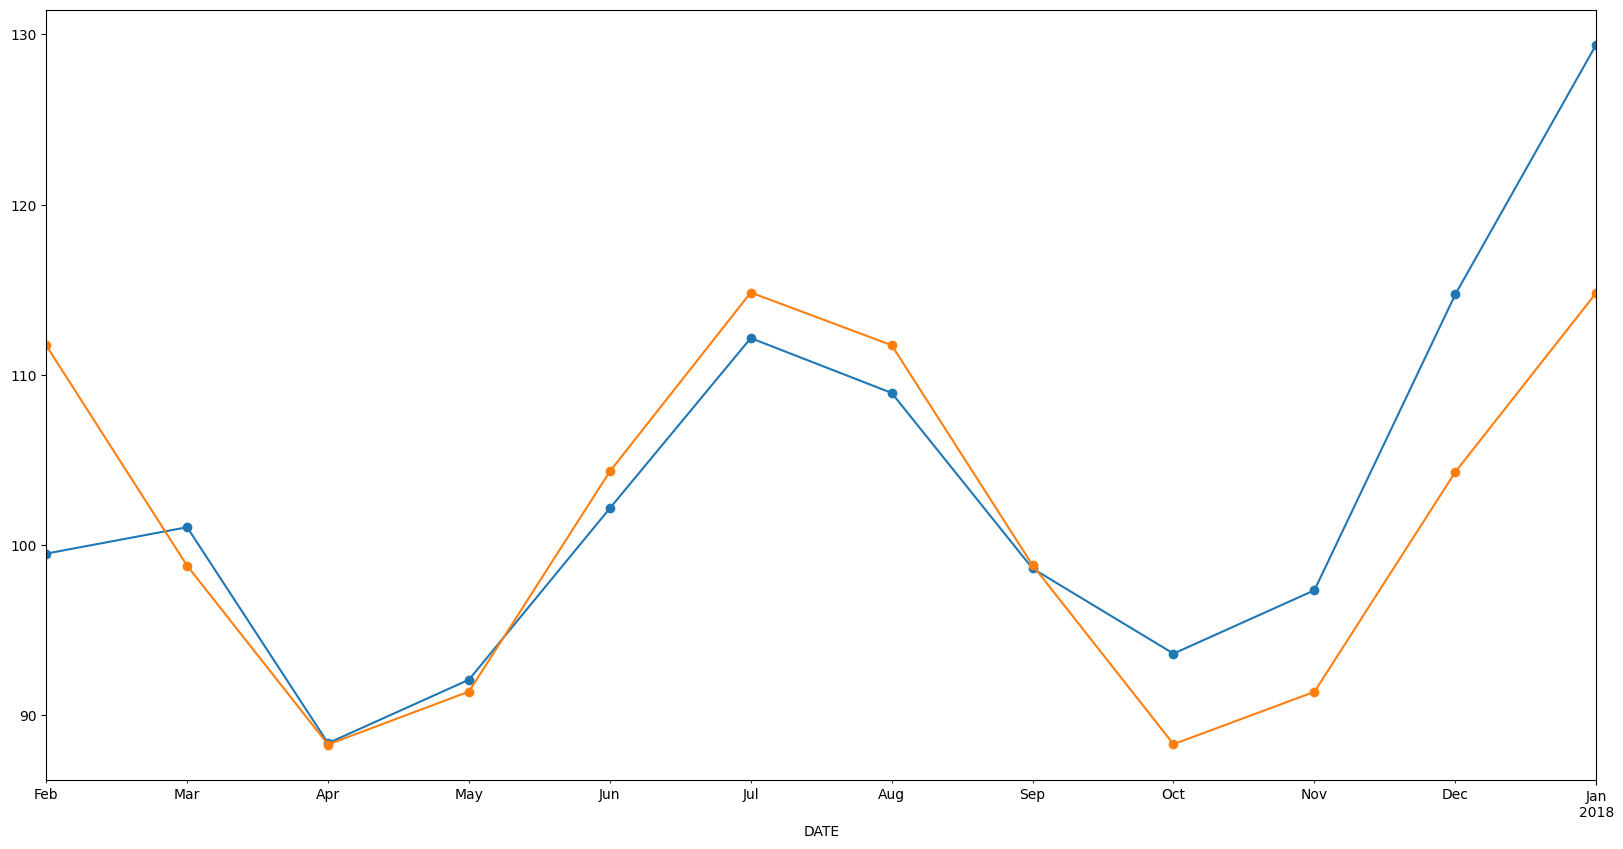

In [70]:
model = SARIMAX(train_x.values, order=(3, 1, 3)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

test_x['values'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['values'], test_x['pred'])

### SARIMA (p,q,d,P,Q,D,s)

MAE : 3.23
RMSE : 4.586
MAPE: 0.03


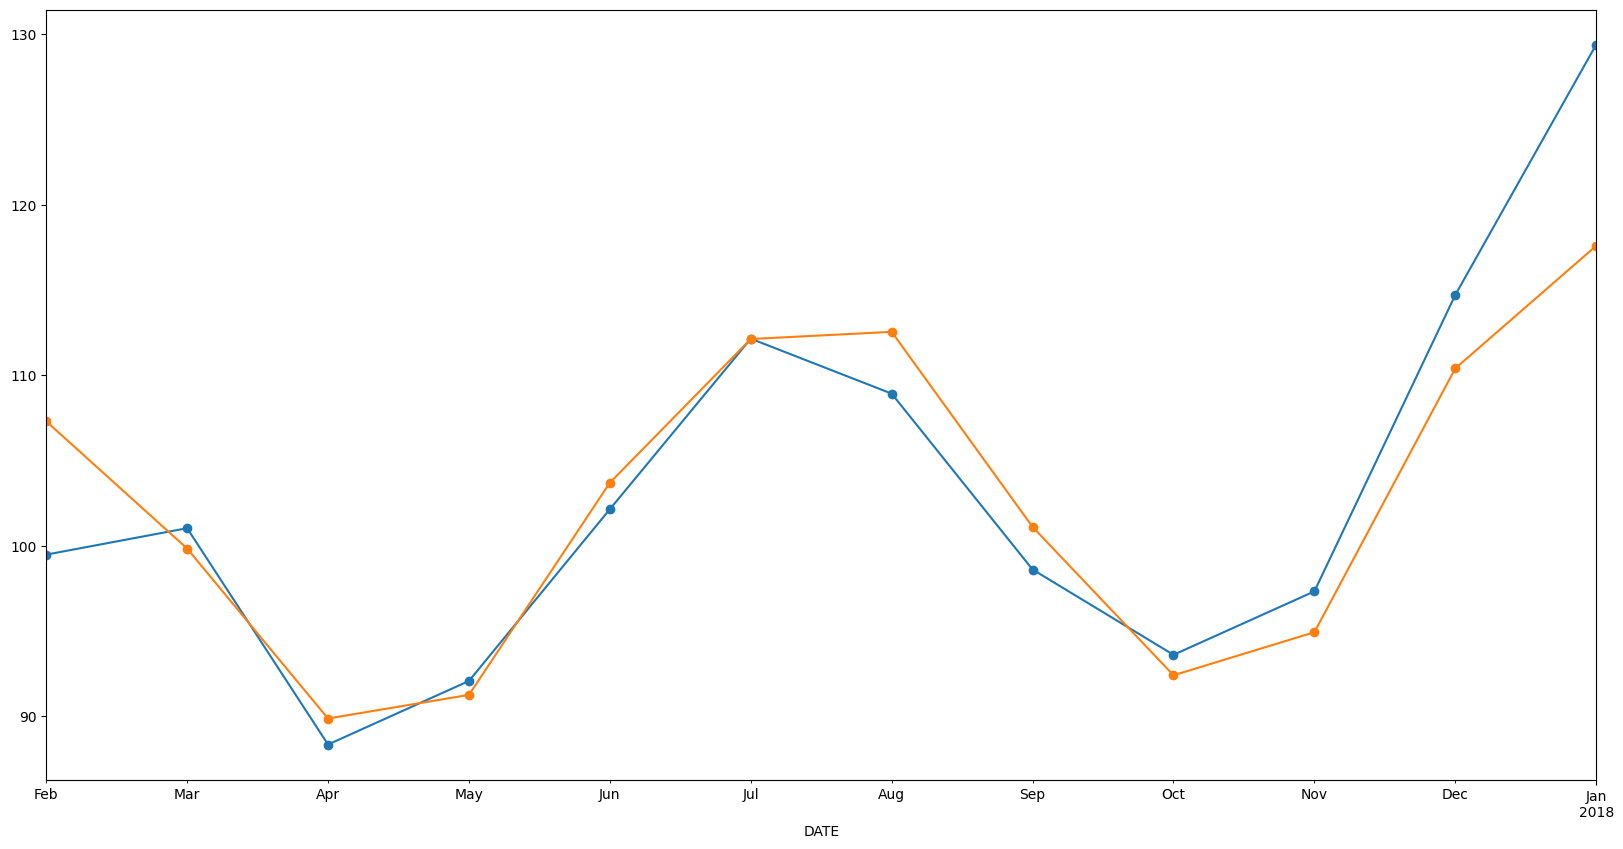

In [68]:
model = SARIMAX(train_x.values, order=(5, 1, 3), seasonal_order=(1,1,1,12)) 
model = model.fit(disp=False)

test_x['pred'] = model.forecast(steps=12)

test_x['values'].plot(style='-o')
test_x['pred'].plot(style='-o')
performance(test_x['values'], test_x['pred'])

## Prophet

- Easy to use library
- In build holiday feature
- Supports multiple seasonality - Weekly, monthly, yearly
- In build CI
- Get a quick ouput - baseline
- Support exog


Cons:
- Not well meantained
- Painful to install
- Not enought things that you can change or control (few HP)
- Does not do well for certain time-series

These instructions work on Google Colab

```
pip install pystan~=2.14
pip install fbprophet
```

In [ ]:
df = df1.copy()